In [23]:
import os
import pandas as pd
import gensim
from gensim.models import KeyedVectors
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.regularizers import l2

### Declare path

In [2]:
data_dir_path = 'sport-text-classification-ball-isi-public'
train_path = os.path.join(data_dir_path, 'train\\train.tsv')
dev_texts_path = os.path.join(data_dir_path, 'dev-0\\in.tsv')
dev_labels_path = os.path.join(data_dir_path, 'dev-0\\expected.tsv')
dev_predicted_path = os.path.join(data_dir_path, 'dev-0\\out.tsv')
test_texts_path = os.path.join(data_dir_path, 'test-A\\in.tsv')
test_predicted_path = os.path.join(data_dir_path, 'test-A\\out.tsv')
word2vec_file_path = 'word2vec_100_3_polish.bin'

### Load files

In [3]:
train_data = pd.read_csv(train_path, sep='\t', usecols=[0, 1], header=None, names=['label', 'text'])
dev_texts_data = pd.read_csv(dev_texts_path, sep='\t', usecols=[0], header=None, names=['text'])
dev_labels_data = pd.read_csv(dev_labels_path, sep='\t', usecols=[0], header=None, names=['label'])
test_texts_data = pd.read_csv(test_texts_path, sep='\t', usecols=[0], header=None, names=['text'])

### Load word2vec

In [4]:
word2vec = KeyedVectors.load(word2vec_file_path)

### Preprocess data

In [5]:
def text_to_word2vec(text):
    text_vector = np.mean([word2vec[word] for word in text if word in word2vec], axis=0).tolist()
    if np.isnan(text_vector).any() or not isinstance(text_vector, list):
        return np.zeros(word2vec.vector_size)
    return text_vector

def fit_data(column):
    return np.array(column.tolist())

def fit_data_X(text_column):
    text_preprocessed = text_column.apply(lambda x: gensim.utils.simple_preprocess(x))
    vectors = text_preprocessed.apply(lambda x: text_to_word2vec(x))
    return fit_data(vectors)

train_X = fit_data_X(train_data['text'])
train_Y = fit_data(train_data['label'])
dev_X = fit_data_X(dev_texts_data['text'])
dev_Y = fit_data(dev_labels_data['label'])
test_X = fit_data_X(test_texts_data['text'])

C:\Users\Pawel\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


### Create model

In [6]:
model = Sequential()
model.add(Dense(128, input_dim=train_X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Compile model

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train model

In [8]:
history = model.fit(train_X, train_Y, epochs=20, batch_size=32, validation_data=(dev_X, dev_Y))

Epoch 1/20


3067/3067 [==============================] - 17s 4ms/step - loss: 0.1955 - accuracy: 0.9319 - val_loss: 0.1569 - val_accuracy: 0.9404
Epoch 2/20
3067/3067 [==============================] - 11s 4ms/step - loss: 0.1393 - accuracy: 0.9471 - val_loss: 0.1337 - val_accuracy: 0.9450
Epoch 3/20
3067/3067 [==============================] - 10s 3ms/step - loss: 0.1264 - accuracy: 0.9523 - val_loss: 0.1410 - val_accuracy: 0.9426
Epoch 4/20
3067/3067 [==============================] - 15s 5ms/step - loss: 0.1189 - accuracy: 0.9543 - val_loss: 0.1231 - val_accuracy: 0.9516
Epoch 5/20
3067/3067 [==============================] - 16s 5ms/step - loss: 0.1133 - accuracy: 0.9570 - val_loss: 0.1206 - val_accuracy: 0.9490
Epoch 6/20
3067/3067 [==============================] - 17s 6ms/step - loss: 0.1076 - accuracy: 0.9588 - val_loss: 0.1220 - val_accuracy: 0.9481
Epoch 7/20
3067/3067 [==============================] - 11s 4ms/step - loss: 0.1039 - accuracy: 0.9605 - val_loss: 0.1125 - val_

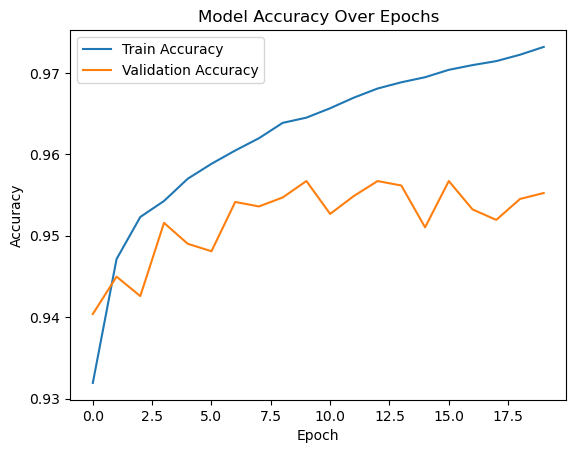

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

### Predict and save results

In [26]:
def predict_and_save(X, filename):
    Y_predicted = model.predict(X)
    Y_predicted = np.round(Y_predicted,0).astype(int)
    Y_predicted_df = pd.DataFrame(Y_predicted, columns=['predicted_label'])
    Y_predicted_df.to_csv(filename, sep='\t', index=False, header=None)

In [27]:
dev_predicted = predict_and_save(dev_X, dev_predicted_path)
test_predicted = predict_and_save(test_X, test_predicted_path)

171/171 [==============================] - 1s 3ms/step
